# YOLOv7

In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Convert to the YOLOv7 Annotation Format

In [2]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [20]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"helmet": 0,
                           "person": 1,
                           "head": 2}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict, helmet, personas, head):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        if (class_id == 0):
            helmet += 1

        if (class_id == 1):
            personas += 1

        if (class_id == 2):
            head += 1

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save 
    save_file_name = os.path.join("safety-helmet-dataset/annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

    return helmet, personas, head

In [21]:
# Cantidad BB de Personas
helmet = 0
personas = 0
head = 0

# Get the annotations
annotations = [os.path.join('safety-helmet-dataset/annotationsDS', x) for x in os.listdir('safety-helmet-dataset/annotationsDS') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    helmet, personas, head = convert_to_yolov5(info_dict, helmet, personas, head)
annotations = [os.path.join('safety-helmet-dataset/annotations', x) for x in os.listdir('safety-helmet-dataset/annotations') if x[-3:] == "txt"]

print(helmet)
print(personas)
print(head)

100%|██████████| 5000/5000 [00:06<00:00, 827.38it/s]

18966
751
5785


### Testing the annotations

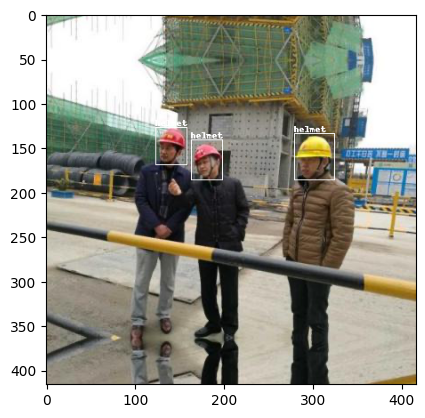

In [6]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("safety-helmet-dataset/annotations", "safety-helmet-dataset/imagesDS").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

### Partition the Dataset

In [7]:
# Read images and annotations
images = [os.path.join('safety-helmet-dataset/imagesDS', x) for x in os.listdir('safety-helmet-dataset/imagesDS')]
annotations = [os.path.join('safety-helmet-dataset/annotations', x) for x in os.listdir('safety-helmet-dataset/annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [8]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'safety-helmet-dataset/images/train/')
move_files_to_folder(val_images, 'safety-helmet-dataset/images/val/')
move_files_to_folder(test_images, 'safety-helmet-dataset/images/test/')
move_files_to_folder(train_annotations, 'safety-helmet-dataset/labels/train/')
move_files_to_folder(val_annotations, 'safety-helmet-dataset/labels/val/')
move_files_to_folder(test_annotations, 'safety-helmet-dataset/labels/test/')

### YOLOv7 Safety Helmet Detection v1

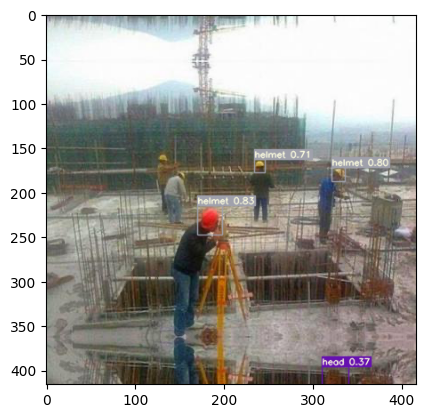

In [25]:
detections_dir = "runs/detect/yolo7_safety_helmet_detection/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

### YOLOv7 Safety Helmet Detection v2

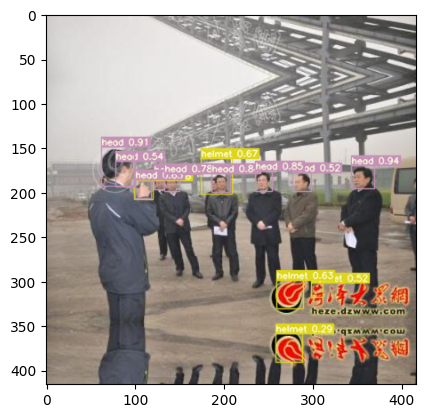

In [15]:
detections_dir = "runs/detect/yolo7_safety_helmet_detection_v2/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

### YOLOv7 Safety Helmet Detection v3

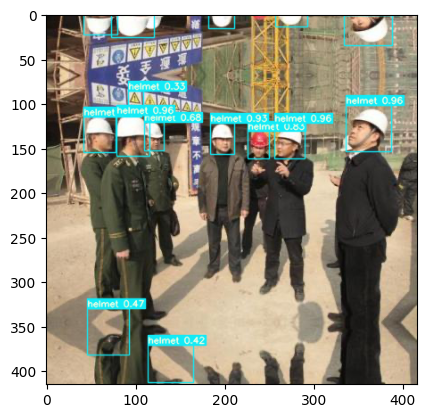

In [162]:
detections_dir = "runs/detect/yolo7_safety_helmet_detection_v3/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

### YOLOv7 Safety Helmet Detection v4

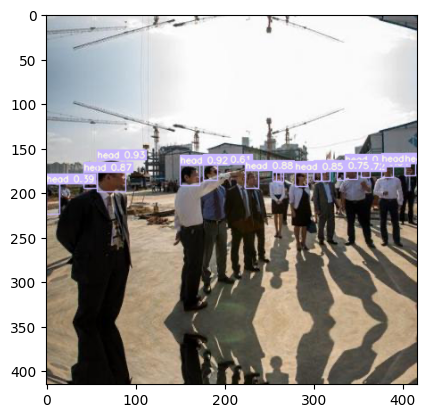

In [40]:
detections_dir = "runs/detect/yolo7_safety_helmet_detection_v4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

### YOLOv7 Safety Helmet Detection Pruebas

In [ ]:
!py detect.py --source pruebas\ --weights runs\train\yolo7_safety_helmet_detection_v4\weights\best.pt --conf 0.25 --name pruebas  

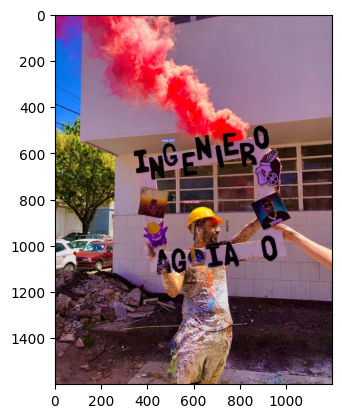

In [14]:
detections_dir = "runs/detect/pruebas/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))